### Import required packages

In [1]:
import pandas as pd

### Download and prep NASA's Turbofan Engine Degradation Simulation (PHM08 Challenge) Data Set
##### Download data from https://ti.arc.nasa.gov/c/13/
##### Create a folder path of /home/sasdemo/NASA/

In [2]:
### point to NASA Turbofan Engine Degradation Simulation Train.txt Data Set
df=pd.read_table('train.txt', delim_whitespace=True, 
                  names=['engine','cycle','x1','x2','x3','x4','x5','x6','x7','x8','x9','x10','x11','x12','x13',
                         'x14','x15','x16','x17','x18','x19','x20','x21','x22','x23','x24'])
df.head()

,engine,cycle,x1,x2,x3,x4,x5,x6,x7,x8,...,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24
0,1,1,10.0047,0.2501,20.0,489.05,604.13,1499.45,1309.95,10.52,...,372.15,2388.13,8120.83,8.6216,0.03,368,2319,100.0,28.58,17.1735
1,1,2,0.0015,0.0003,100.0,518.67,642.13,1584.55,1403.96,14.62,...,521.81,2388.15,8132.87,8.3907,0.03,391,2388,100.0,38.99,23.3619
2,1,3,34.9986,0.8401,60.0,449.44,555.42,1368.17,1122.49,5.48,...,183.26,2387.95,8063.84,9.3557,0.02,334,2223,100.0,14.83,8.8555
3,1,4,20.0031,0.7005,0.0,491.19,607.03,1488.44,1249.18,9.35,...,314.84,2388.07,8052.30,9.2231,0.02,364,2324,100.0,24.42,14.7832
4,1,5,42.0041,0.8405,40.0,445.00,549.52,1354.48,1124.32,3.91,...,130.44,2387.89,8083.67,9.2986,0.02,330,2212,100.0,10.99,6.4025


In [3]:
### Create training data with 30 random engines
train=df[df['engine'].isin([7,28,32,38,40,51,65,84,90,95,99,107,120,124,135,137,138,148,
                          151,160,166,178,182,188,197,199,200,207,210,211])]
### Keep first 50 observations per engine to train SVDD 
train=train[train['cycle']<=50]
train['index'] = train.index

### Check training table
train.tail()

,engine,cycle,x1,x2,x3,x4,x5,x6,x7,x8,...,x16,x17,x18,x19,x20,x21,x22,x23,x24,index
44296,211,46,0.0019,0.0015,100.0,518.67,642.32,1585.44,1403.71,14.62,...,2388.05,8136.64,8.4008,0.03,392,2388,100.00,38.94,23.4167,44296
44297,211,47,25.0045,0.6204,80.0,462.54,536.09,1261.04,1043.58,7.05,...,2028.23,7877.28,10.8351,0.02,306,1915,84.93,14.33,8.5657,44297
44298,211,48,25.0009,0.6200,80.0,462.54,536.70,1258.17,1045.69,7.05,...,2028.16,7868.87,10.8982,0.02,307,1915,84.93,14.15,8.5617,44298
44299,211,49,34.9992,0.8400,60.0,449.44,555.55,1357.05,1124.54,5.48,...,2387.98,8060.58,9.3039,0.02,333,2223,100.00,15.05,9.0326,44299
44300,211,50,34.9985,0.8401,60.0,449.44,555.79,1361.79,1115.64,5.48,...,2388.03,8065.22,9.2908,0.02,334,2223,100.00,14.88,9.0062,44300


In [4]:
### point to NASA Turbofan Engine Degradation Simulation Test.txt Data Set
df=pd.read_table('test.txt', delim_whitespace=True, 
                  names=['engine','cycle','x1','x2','x3','x4','x5','x6','x7','x8','x9','x10','x11','x12','x13',
                         'x14','x15','x16','x17','x18','x19','x20','x21','x22','x23','x24'])

### create a scoring data set with 9 random engines from the test data set
df['index'] = df.index
score=df[df['engine'].isin([1,8,22,53,63,86,102,158,170,202])]
score.tail()

,engine,cycle,x1,x2,x3,x4,x5,x6,x7,x8,...,x16,x17,x18,x19,x20,x21,x22,x23,x24,index
27762,202,220,25.0016,0.6200,80.0,462.54,536.90,1269.39,1060.73,7.05,...,2028.26,7871.43,10.9634,0.02,310,1915,84.93,14.24,8.4615,27762
27763,202,221,0.0028,0.0000,100.0,518.67,643.27,1598.17,1421.01,14.62,...,2388.21,8138.45,8.4976,0.03,395,2388,100.00,38.68,23.1797,27763
27764,202,222,34.9982,0.8400,60.0,449.44,555.96,1377.66,1141.88,5.48,...,2388.13,8069.36,9.3483,0.02,335,2223,100.00,14.69,8.9512,27764
27765,202,223,25.0020,0.6208,80.0,462.54,537.21,1267.70,1063.08,7.05,...,2028.27,7878.83,11.0023,0.02,309,1915,84.93,14.22,8.4076,27765
27766,202,224,24.9998,0.6200,80.0,462.54,537.08,1270.70,1064.61,7.05,...,2028.28,7884.13,10.9798,0.02,309,1915,84.93,14.13,8.4066,27766


### Connect to SAS Viya CAS Engine

In [5]:
### Import Scripting Wrapper for Analytics Transfer (SWAT) package allowing user to execute CAS actions from Python
import swat

In [6]:
### Connect to CAS engine with licensed host, path, username and 
casauth='~/_authinfo'
s = swat.CAS(cashost, casport, authinfo=casauth, caslib="casuser")
if s:
   sid = s.session.sessionid()
   for v in sid:
       print("auto.py: Connected to " + ":" + " sess: " + sid[v])
else:
   print("auto.py: Not connected")

auto.py: Connected to : sess: 96b612e4-9d54-e94b-8751-2901f137d45d


### Load outputDF pandas dataframe into CAS

In [7]:
s.upload(train, casout={"name":'train',"replace":True})
s.upload(score, casout={"name":'score',"replace":True})

NOTE: Cloud Analytic Services made the uploaded file available as table TRAIN in caslib CASUSERHDFS(dishaw).
NOTE: The table TRAIN has been created in caslib CASUSERHDFS(dishaw) from binary data uploaded to Cloud Analytic Services.
NOTE: Cloud Analytic Services made the uploaded file available as table SCORE in caslib CASUSERHDFS(dishaw).
NOTE: The table SCORE has been created in caslib CASUSERHDFS(dishaw) from binary data uploaded to Cloud Analytic Services.


[caslib]

 'CASUSERHDFS(dishaw)'

[tableName]

 'SCORE'

[casTable]

 CASTable('SCORE', caslib='CASUSERHDFS(dishaw)')

+ Elapsed: 0.576s, user: 7.69s, sys: 10.2s, mem: 4.7e+03mb

In [8]:
### Check details of loaded data
s.tableinfo()

,Name,Rows,Columns,IndexedColumns,Encoding,CreateTimeFormatted,ModTimeFormatted,AccessTimeFormatted,JavaCharSet,CreateTime,ModTime,AccessTime,Global,Repeated,View,SourceName,SourceCaslib,Compressed,Creator,Modifier
0,TRAIN,1500,27,0,utf-8,03Oct2017:20:24:21,03Oct2017:20:24:21,03Oct2017:20:24:21,UTF8,1.822681e+09,1.822681e+09,1.822681e+09,0,0,0,,,0,dishaw,
1,SCORE,1502,27,0,utf-8,03Oct2017:20:24:21,03Oct2017:20:24:21,03Oct2017:20:24:21,UTF8,1.822681e+09,1.822681e+09,1.822681e+09,0,0,0,,,0,dishaw,


### Import SVDD action set

In [9]:
s.loadactionset(actionset='svdd')

NOTE: Added action set 'svdd'.


[actionset]

 'svdd'

+ Elapsed: 0.0703s, user: 0.247s, sys: 1.03s, mem: 34.2mb

### Create SVDD model for training data

In [10]:
#### run svdd.svddTrain action set on training data
res=s.svdd.svddTrain(table={"name" :'train'}
                     ,gauss=11
                     ,solver="ACTSET"
                     ,inputs=[{"name":"x1"},{"name":"x2"},{"name":"x3"},{"name":"x4"},{"name":"x5"},{"name":"x6"},
                              {"name":"x7"},{"name":"x8"},{"name":"x9"},{"name":"x10"},{"name":"x11"},{"name":"x12"},
                              {"name":"x13"},{"name":"x14"},{"name":"x15"},{"name":"x16"},{"name":"x17"},{"name":"x18"},
                              {"name":"x19"},{"name":"x20"},{"name":"x21"},{"name":"x22"},{"name":"x23"},{"name":"x24"}]
                     ,savestate={"name":"ysvddstate"}
                     ,output={"casout":{"name":"state_s","replace":True}}
                     ,id ="index"
                    )
print (res)

sv=s.fetch(table={"name":"state_s"}, to=1000)
print (sv)

NOTE: Beginning data reading...
NOTE: Data reading complete.
NOTE: Beginning SVDD optimization...
NOTE: SVDD optimization complete.
NOTE: Output generation complete.
NOTE: Beginning of support vector table generation...
NOTE: Support vector table generation complete.
NOTE: Beginning save state generation...
NOTE: Wrote 37269 bytes to the savestate file ysvddstate.
NOTE: Save state generation complete.
[ModelInfo]

 Model Information
 
        RowId                   Description        Value     nValue
 0  OPTMETHOD           Optimization Method   Active set        NaN
 1    KERTYPE                   Kernel Type          RBF        NaN
 2         BW          RBF Kernel Bandwidth           11  11.000000
 3   RELSCALE      Bandwidth Relative Scale  0.089542561   0.089543
 4       FRAC     Expected Outlier Fraction         1E-6   0.000001
 5     OPTTOL        Optimization Tolerance       0.0001   0.000100
 6   NINTVARS  Number of Interval Variables           24  24.000000
 7   NNOMVARS   N

### Score SVDD astore against scoring data

In [11]:
#### load astore action set
s.loadactionset(actionset="astore")

NOTE: Added action set 'astore'.


[actionset]

 'astore'

+ Elapsed: 0.0647s, user: 0.238s, sys: 0.897s, mem: 33.5mb

In [12]:
#### score resulting SVDD astore (ysvddstate) against the scoring data (score) and output results (svddscored)
res2 = s.aStore.score(table="score", rstore="ysvddstate", out={"name":"svddscored","replace":True})
print (res2)

[Timing]

 Task Timing
 
                  Task   Seconds   Percent
 0   Loading the Store  0.043919  0.092280
 1  Creating the State  0.122353  0.257079
 2             Scoring  0.309659  0.650633
 3               Total  0.475935  1.000000

+ Elapsed: 0.583s, user: 8.99s, sys: 9.08s, mem: 5.23e+03mb


In [13]:
### create local dataframe of scored data to plot using Matplotlib
output = s.fetch(table="svddscored",to=1000,maxrows=1000)['Fetch']
output.head()

,index,_SVDDDISTANCE_,_SVDDSCORE_
0,0.0,0.953049,-1.0
1,1.0,1.008137,1.0
2,2.0,0.957279,-1.0
3,3.0,0.966300,-1.0
4,4.0,0.960594,-1.0


In [14]:
### add SVDD scored values to original score dataframe for plotting purposes
df=score.merge(output,how='left')
df.head()

,engine,cycle,x1,x2,x3,x4,x5,x6,x7,x8,...,x18,x19,x20,x21,x22,x23,x24,index,_SVDDDISTANCE_,_SVDDSCORE_
0,1,1,0.0016,0.0002,100.0,518.67,642.88,1587.21,1412.44,14.62,...,8.4363,0.03,393,2388,100.00,38.97,23.3029,0,0.953049,-1.0
1,1,2,24.9993,0.6215,80.0,462.54,536.45,1262.64,1055.44,7.05,...,10.8935,0.02,308,1915,84.93,14.29,8.6686,1,1.008137,1.0
2,1,3,0.0004,0.0000,100.0,518.67,642.65,1589.75,1409.54,14.62,...,8.4620,0.03,393,2388,100.00,38.91,23.2693,2,0.957279,-1.0
3,1,4,10.0034,0.2500,20.0,489.05,604.44,1499.93,1315.34,10.52,...,8.6815,0.03,369,2319,100.00,28.60,17.0930,3,0.966300,-1.0
4,1,5,0.0024,0.0011,100.0,518.67,642.74,1585.47,1408.12,14.62,...,8.4617,0.03,392,2388,100.00,38.82,23.3124,4,0.960594,-1.0


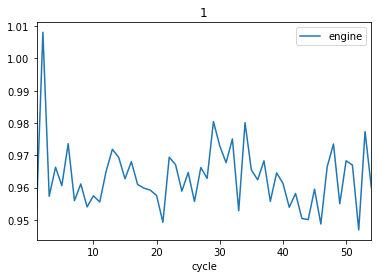

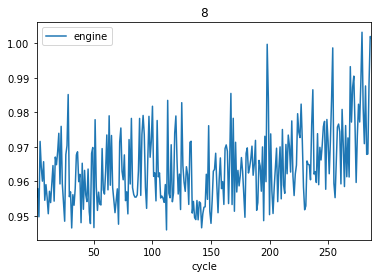

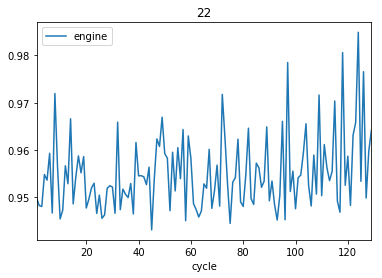

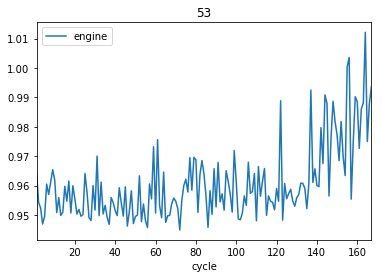

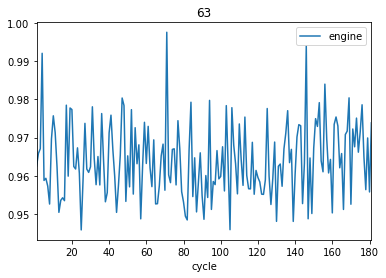

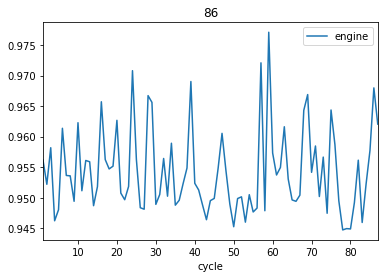

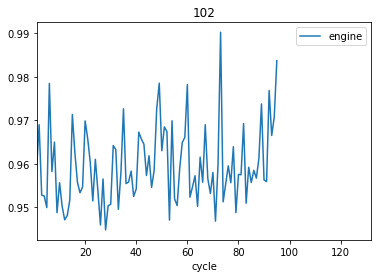

In [15]:
import matplotlib.pyplot as plt

df = df.loc[df['engine']<150]
for index, group in df.groupby('engine'):
    group.plot(x='cycle', y='_SVDDDISTANCE_', title=index, label='engine')

plt.show()

### Save SVDD astore for use in SAS Event Stream Processing

In [16]:
#### download SVDD astore for use in SAS Event Stream Processing (ESP)
results=s.aStore.download(rstore={"name":"ysvddstate"})

In [17]:
### Check details of loaded data
s.tableinfo()

,Name,Rows,Columns,IndexedColumns,Encoding,CreateTimeFormatted,ModTimeFormatted,AccessTimeFormatted,JavaCharSet,CreateTime,ModTime,AccessTime,Global,Repeated,View,SourceName,SourceCaslib,Compressed,Creator,Modifier
0,TRAIN,1500,27,0,utf-8,03Oct2017:20:24:21,03Oct2017:20:24:21,03Oct2017:20:27:12,UTF8,1.822681e+09,1.822681e+09,1.822682e+09,0,0,0,,,0,dishaw,
1,SCORE,1502,27,0,utf-8,03Oct2017:20:24:21,03Oct2017:20:24:21,03Oct2017:20:27:26,UTF8,1.822681e+09,1.822681e+09,1.822682e+09,0,0,0,,,0,dishaw,
2,STATE_S,133,27,0,utf-8,03Oct2017:20:27:12,03Oct2017:20:27:12,03Oct2017:20:27:13,UTF8,1.822682e+09,1.822682e+09,1.822682e+09,0,0,0,,,0,dishaw,
3,YSVDDSTATE,1,2,0,utf-8,03Oct2017:20:27:13,03Oct2017:20:27:13,03Oct2017:20:27:42,UTF8,1.822682e+09,1.822682e+09,1.822682e+09,0,1,0,,,0,dishaw,
4,SVDDSCORED,1502,3,0,utf-8,03Oct2017:20:27:26,03Oct2017:20:27:26,03Oct2017:20:27:29,UTF8,1.822682e+09,1.822682e+09,1.822682e+09,0,0,0,,,0,dishaw,


### See ESP_Turbofan_Degradation.mp4 video to see how SVDD astore code is used to score new observation in SAS Event Stream Processing 